## Assignment 8 - Evaluation##

In [1]:
#%pylab inline
%matplotlib inline 

import pandas as pd

In [2]:
names = pd.read_csv('names', header=None)
data = pd.read_csv('./hepatitis.data', names=names.values[0], header=None)

While there aren't multiclass groups here, missing values weren't handled very well last time, so this is an opportunity to use something better.  In this case the median value of the feature with a missing value for its class is used.

In [3]:
import numpy as np
def _missing_map(data, label, map_type,  method=np.median, missing='?', class_lab='CLASS'):
    classes = data[data[label] == missing][class_lab].drop_duplicates().values
    means = {}
    for cl in classes:
        
        means[cl] = method(list(map(map_type, data[(data[class_lab] == cl) & 
                                                   (data[label] != missing)][label].values)))
    return means

def set_missing_as_median_by_class(data, label, map_type, missing='?'):
    missing_map_vals = _missing_map(data, label, map_type, missing=missing, class_lab='CLASS')
    for cl in missing_map_vals.keys():
        repl = data[data.CLASS == cl][label].replace([missing], missing_map_vals[cl], regex=False)
        data.loc[data.CLASS == cl, label] = repl

# int values
for feat in ['STEROID', 'FATIGUE', 'ANOREXIA', 'LIVER_BIG', 'LIVER_FIRM', 
             'SPIDERS', 'ASCITES', 'VARICES',  'MALAISE',   'SPLEEN_PALPABLE']:
    set_missing_as_median_by_class(data, feat, int)
# float values
for feat in ['BILIRUBIN', 'ALKPHOSPHATE',
             'SGOT',    'ALBUMIN', 'PROTIME']:
    set_missing_as_median_by_class(data, feat, float)

Oversampling the minority class with regular SMOTE to get better results.

In [4]:
from imblearn.over_sampling import SMOTE
rseed=100
sm = SMOTE(random_state=rseed)
X_res, y_res = sm.fit_sample(data[data.columns.drop(['CLASS'])], data['CLASS'])
X_res = pd.DataFrame(X_res, columns=data.columns.drop(['CLASS']))
y_res = pd.Series(y_res, name='CLASS')

Explicitly stratify the training set in case it wasn't done last time.

In [5]:
from sklearn import tree, model_selection

data_train, data_test, labels_train, labels_test = model_selection.train_test_split(X_res, y_res, random_state=rseed, test_size=0.15, stratify=y_res)
print("Training set:\n{}".format(labels_train.value_counts()))
print("Test set:\n{}".format(labels_test.value_counts()))

Training set:
2    105
1    104
Name: CLASS, dtype: int64
Test set:
1    19
2    18
Name: CLASS, dtype: int64


In [6]:
clf2 = tree.DecisionTreeClassifier(max_features='auto', max_depth=6, random_state=rseed, presort=True)
fit = clf2.fit(data_train, labels_train)

### 1 ###

From here on we'll define class 1 (DIE) as positive and class 2 (LIVE) as negative.

With the modifications, the accuracy of the decision tree has gone up slighly.

In [7]:
print("Accuracy: {}".format(clf2.score(data_test, labels_test)))

Accuracy: 0.8648648648648649


### 2 ###

In [8]:
from sklearn.metrics import precision_score, recall_score

class_predict = clf2.predict(data_test)
print("Precision: {}".format(precision_score(labels_test, class_predict)))
print("Recall: {}".format(recall_score(labels_test, class_predict)))

Precision: 0.85
Recall: 0.8947368421052632


### 3 ###

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(labels_test, class_predict))

             precision    recall  f1-score   support

          1       0.85      0.89      0.87        19
          2       0.88      0.83      0.86        18

avg / total       0.87      0.86      0.86        37



### 4 ###

Confusion matrix, without normalization
[[17  2]
 [ 3 15]]


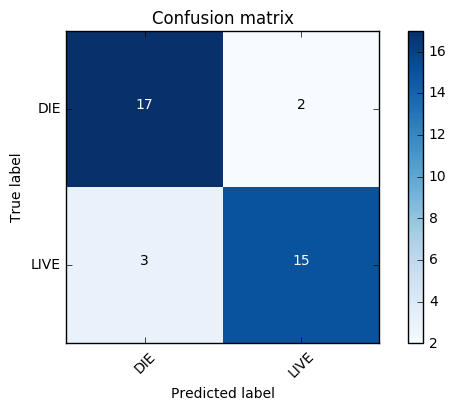

In [10]:
import itertools
import matplotlib.pyplot as plt

# plot_confusion_matrix taken from: 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
matrix = confusion_matrix(labels_test, class_predict, labels=[1, 2])
plt.figure()
plot_confusion_matrix(matrix, classes=['DIE', 'LIVE'],
                      title='Confusion matrix')
plt.show()

### 5 ###

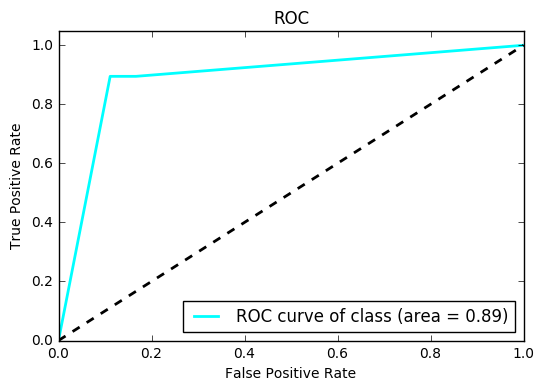

In [11]:
# Mostly borrowed from:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(labels_test==1, clf2.predict_proba(data_test)[:,0])
roc_auc = auc(fpr, tpr)

# Compute ROC curve and ROC area

# Plot all ROC curves
plt.figure()
plt.plot(fpr, tpr, 'aqua', lw=2,
         label='ROC curve of class (area = {0:0.2f})'.format(roc_auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

### 6 ###

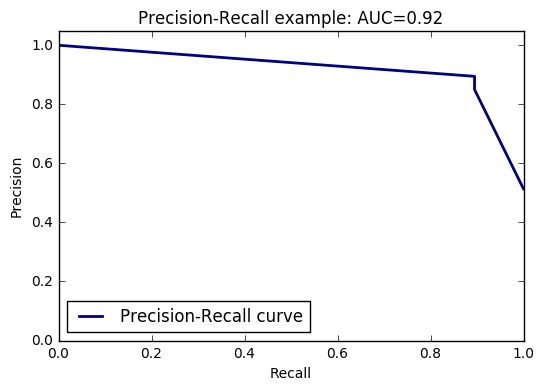

In [12]:
# Mostly borrowed from:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(labels_test==1, clf2.predict_proba(data_test)[:,0])
average_precision = average_precision_score(labels_test==1, clf2.predict_proba(data_test)[:,0])

plt.clf()
plt.plot(recall, precision, lw=2, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
plt.show()